In [40]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [38]:
# defining train and test data path
train_dir = "/content/drive/MyDrive/covid19/covid19/train"
test_dir = "/content/drive/MyDrive/covid19/covid19/test"

In [39]:
BATCH_SIZE = 32
IMAGE_SIZE = (100,100)


In [ ]:
#converting dataset in different folders into classes and batches
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir ,
                                                               image_size = IMAGE_SIZE ,
                                                               batch_size = BATCH_SIZE,
                                                               label_mode = "int")

Found 251 files belonging to 3 classes.


In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir ,
                                                               batch_size = BATCH_SIZE,
                                                               image_size = IMAGE_SIZE,
                                                               label_mode = "int")

Found 66 files belonging to 3 classes.


In [ ]:
valid_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names , num_classes)

['Covid', 'Normal', 'Viral Pneumonia'] 3


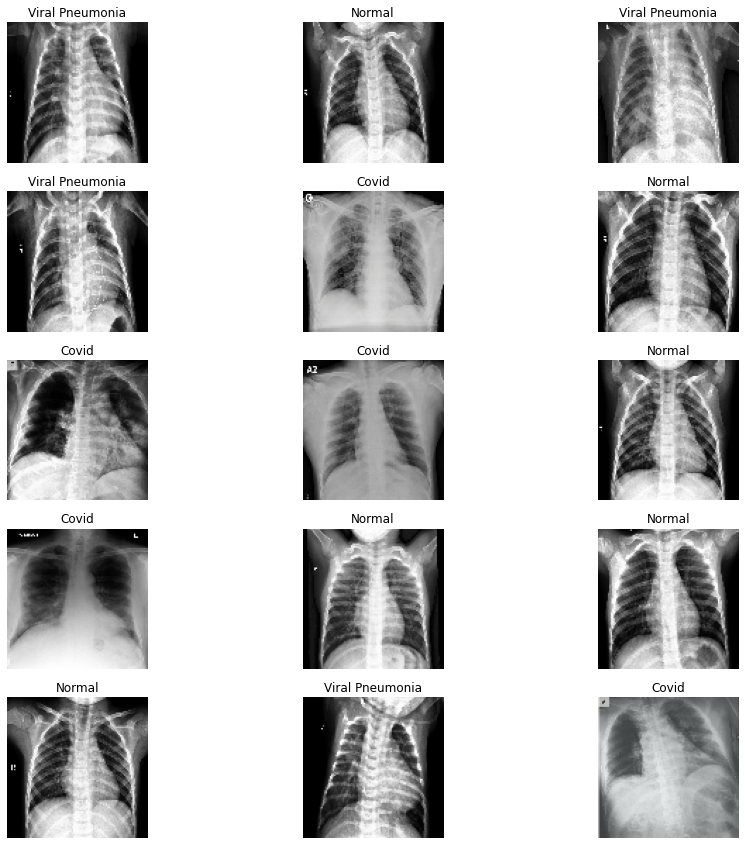

In [ ]:
# visusalising valid data
import matplotlib.pyplot as plt

plt.figure(figsize = (15,15))

for img , label in valid_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5,3,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")



In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [36]:
#standardizing data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [44]:

zoom_layer = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (0.1 , 0.3) , width_factor = (0.1 , 0.3))
rot_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(factor = .2)
flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal" , input_shape = IMAGE_SIZE)


In [42]:
normalized_ds = train_ds.map(lambda x , y : (normalization_layer(x) , y))
image_batch , label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image) , np.max(first_image))

0.0 1.0


In [51]:
# defining model function

def get_model(num_classes):
  model = Sequential([
                      normalization_layer,
                      zoom_layer,
                      rot_layer , 
                      flip_layer,
                      Conv2D(16 , (5,5) , padding="same" , activation="relu"),
                      MaxPool2D((2,2)),
                      BatchNormalization(),
                      Dropout(0.2),

                      Conv2D(32, (5,5) , padding = "same" , activation = "relu"),
                      MaxPool2D((2,2)),
                      Dropout(0.3),

                      Conv2D(64, (5,5) , padding = "same" , activation = "relu"),
                      MaxPool2D((2,2)),
                      Dropout(0.3),

                      Flatten(),
                      Dense(256 , activation = "relu"),
                      Dropout(0.3),
                      Dense(num_classes , activation = "softmax")
            
  ])
  model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False , reduction = tf.keras.losses.Reduction.AUTO),
                metrics = ["accuracy"])
  
  return model


In [52]:
model = get_model(num_classes = num_classes)

In [53]:
history = model.fit(train_ds , validation_data=valid_ds , epochs = 75 )

Epoch 1/75
8/8 [==============================] - 11s 802ms/step - loss: 1.2501 - accuracy: 0.3865 - val_loss: 1.0602 - val_accuracy: 0.6212
Epoch 2/75
8/8 [==============================] - 10s 781ms/step - loss: 0.9952 - accuracy: 0.5498 - val_loss: 1.0509 - val_accuracy: 0.6515
Epoch 3/75
8/8 [==============================] - 10s 779ms/step - loss: 0.7863 - accuracy: 0.6813 - val_loss: 1.0302 - val_accuracy: 0.6667
Epoch 4/75
8/8 [==============================] - 10s 775ms/step - loss: 0.7262 - accuracy: 0.6574 - val_loss: 0.9963 - val_accuracy: 0.6818
Epoch 5/75
8/8 [==============================] - 10s 785ms/step - loss: 0.6155 - accuracy: 0.7171 - val_loss: 0.9595 - val_accuracy: 0.6667
Epoch 6/75
8/8 [==============================] - 10s 778ms/step - loss: 0.5668 - accuracy: 0.7689 - val_loss: 0.9200 - val_accuracy: 0.6667
Epoch 7/75
8/8 [==============================] - 10s 777ms/step - loss: 0.4489 - accuracy: 0.8167 - val_loss: 0.9004 - val_accuracy: 0.6667
Epoch 8/75
8/

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [55]:
test_data_gen = ImageDataGenerator()
test_ds = test_data_gen.flow_from_directory(test_dir ,
                                            target_size = IMAGE_SIZE , 
                                            batch_size = 1,
                                            class_mode = "categorical",
                                            color_mode = "rgb",
                                            shuffle = False ,
                                            seed = 2021)

Found 66 images belonging to 3 classes.


In [56]:
test_ds.reset()
preds = model.predict(test_ds)

In [57]:
preds.shape

(66, 3)

In [66]:
pred_indices = np.argmax(preds , axis = 1)
labels = test_ds.class_indices

In [67]:
labels = dict((v,k) for k , v in labels.items())

In [61]:
pred_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2])

In [68]:
labels

{0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'}

In [69]:
predicted_labels = [labels[k] for k in pred_indices]
filenames = test_ds.filenames

In [70]:
import pandas as pd
result = pd.DataFrame({"Filenames" : filenames , "Prediction":predicted_labels})

In [79]:
result.head(60)

,Filenames,Prediction
0,Covid/0100.jpeg,Covid
1,Covid/0102.jpeg,Covid
2,Covid/0105.png,Covid
3,Covid/0106.jpeg,Covid
4,Covid/0108.jpeg,Covid
5,Covid/0111.jpg,Covid
6,Covid/0112.jpg,Covid
7,Covid/0113.jpg,Covid
8,Covid/0115.jpeg,Covid
9,Covid/0118.jpeg,Covid


In [80]:
model.save("/content/drive/MyDrive/covid19/covid19/covid-model.h5")